In [1]:
from datasets import load_dataset
from torchvision import transforms
import json
"""
Parameters:

- datset_name: also include train/test split

- k: the number of results to show

- unmatch: a dictionary storing uid and list of unmatched indices.

NOTE: need to provicde classes as a list if labels are numerical ELSE LEFT THE CLASSES LIST EMPTY
NOTE: Change the prompts in the last section!
"""

dataset_name = "cub"
split = "test"
# hf_dataset = load_dataset("clip-benchmark/wds_vtab-pets", split="train", streaming=False)

unmatch = {"s0004506": [1]}

# unmatch = {}

threshold = 4
k = 5
num_workers = 4

"""LEFT CLASSES LIST EMPTY IF NO NEED TO PROVIDE IT"""
classes = json.load(open(f"data/classes_{dataset_name}.json", "r"))
print(len(classes))

200


In [2]:
if dataset_name == "cifar100":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-cifar100", split=split, streaming=False)
elif dataset_name == "caltech101":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-caltech101", split=split, streaming=False)
elif dataset_name == "food101":
    hf_dataset = load_dataset("clip-benchmark/wds_food101", split=split, streaming=False)
elif dataset_name == "cars":
    hf_dataset = load_dataset("clip-benchmark/wds_cars", split=split, streaming=False)
elif dataset_name == "country211":
    hf_dataset = load_dataset("clip-benchmark/wds_country211", split=split, streaming=False)
elif dataset_name == "sun397":
    hf_dataset = load_dataset("clip-benchmark/wds_sun397", split=split, streaming=False)
elif dataset_name == "fer2013":
    hf_dataset = load_dataset("clip-benchmark/wds_fer2013", split=split, streaming=False)
elif dataset_name == "aircraft":
    hf_dataset = load_dataset("clip-benchmark/wds_fgvc_aircraft", split=split, streaming=False)
elif dataset_name == "imagenetv2":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenetv2", split=split, streaming=False)
elif dataset_name == "imagenet-o":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-o", split=split, streaming=False)
elif dataset_name == "pets":
    hf_dataset = load_dataset("clip-benchmark/wds_vtab-pets", split=split, streaming=False)
elif dataset_name == "imagenet-a":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-a", split=split, streaming=False)
elif dataset_name == "imagenet-r":
    hf_dataset = load_dataset("clip-benchmark/wds_imagenet-r", split=split, streaming=False)
elif dataset_name == "cub":
    hf_dataset = load_dataset("lxs784/cub-200-2011-clip-benchmark", split=split, streaming=False)

if "webp" in hf_dataset[0] and hf_dataset[0]["webp"] is not None:
    image_key = "webp"
elif hf_dataset[0]["jpg"] is not None:
    image_key = "jpg"
    
dataset_name += "-" + split
print(dataset_name)

cub-test


# Load local HF dataset and laion400m dataset

## Load dataset from Huggingface

Optimize hf dataset for fast search and retrival.

In [3]:
import os
import io
import json
from PIL import Image
import imagehash
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class HFDataset(Dataset):

    def __init__(self, root_dir, index_file, lookup=None, transform=None):
        self.root_dir = root_dir
        with open(os.path.join(root_dir, index_file), "r") as f:
            self.index_data = json.load(f)
        self.lookup = lookup
        self.samples = list(self.index_data.items())
        self.uid_to_sample = dict(self.samples)
        self.transform = transform 

    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, index):
        uid, sample = self.samples[index]
        image_path = os.path.join(self.root_dir, sample["image_path"])
        pil_image = Image.open(image_path).convert("RGB")
        text = self.lookup[sample["label"]] if self.lookup else sample["label"]

        ahash = str(imagehash.average_hash(pil_image))
        phash = str(imagehash.phash(pil_image))

        return index, text, ahash, phash, uid

    def get_by_id(self, uid):
        """
        Retrieve a raw PIL image and metadata by its unique identifier.
        """
        if uid not in self.uid_to_sample:
            raise KeyError(f"UID {uid} not found in dataset.")
        sample = self.uid_to_sample[uid]
        image_path = os.path.join(self.root_dir, sample["image_path"])
        pil_image = Image.open(image_path).convert("RGB")
        text = self.lookup[sample["label"]] if self.lookup else sample["label"]
        ahash = str(imagehash.average_hash(pil_image))
        phash = str(imagehash.phash(pil_image))

        return pil_image, text, ahash, phash

('Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Black footed Albatross', 'Laysan Albatross', 'Laysan Albatross') ('ffefcf67c3f3c985', '1f1ff8f7171f0303', 'fff7e4e440c8cdff', 'f8f3e707c1e7cfff', 'ffbf9fcf631fde58', 'fffff3f1e0e6cccc', 'ffffc3e3c3cfcff3', 'ffef83e7f2f0c3c3', '42008bd8c5c3e1ef'

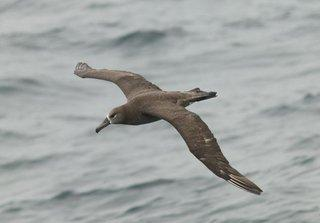

In [4]:
optimized_dir = f"data/optimized_dataset/{dataset_name}"

if not os.path.exists(os.path.join(optimized_dir, "index.json")):
    optimize_hf_to_lightning(hf_dataset, optimized_dir, image_key=image_key, id_key=id_key, label_key=label_key)

dataset = HFDataset(
        index_file = "index.json",
        root_dir=optimized_dir,
        lookup=classes if classes else None,
        # transform = transform
        )

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
for _, texts, ahashes, phashes, uids in dataloader:
    print(texts, ahashes, phashes, uids)
    break
sample_uid = dataset.samples[0][0]
pil_image, text, ahash, phash = dataset.get_by_id(sample_uid)
pil_image.show()

## Load the laion400m dataset

In [1]:
"""load the laion400m dataset for image retrival"""
import os
from lightning_cloud.utils.data_connection import add_s3_connection
from lightning.data import StreamingDataset, StreamingDataLoader
from lightning.data.streaming.serializers import JPEGSerializer
import torchvision.transforms.v2 as T
from tqdm import tqdm
import imagehash
import torchvision.transforms as T
import matplotlib.pyplot as plt 
import numpy as np
import torch
import json
import concurrent
from PIL import Image
import io

# 1. Add the prepared dataset to your teamspace
add_s3_connection("laoin-400m")

# 2. Create the streaming dataset
class LAOINStreamingDataset(StreamingDataset):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.serializer = JPEGSerializer()

    def __getitem__(self, index):
        id, image, text, _, _, _ = super().__getitem__(index)
        
        return Image.open(io.BytesIO(image)), text, str(id), 

laion = LAOINStreamingDataset(input_dir="/teamspace/s3_connections/laoin-400m")

In [2]:
indices = [135090238, 204687600, 273460138, 299247308]
for i in indices:
    print(laion[i][1])

Soyuz Spacecraft Lands Safely with Russian-US Crew
Soyuz Space Capsule Lands Safely With US-Russian Crew
The Soyuz TMA-21 spacecraft is seen as it lands with Expedition 28 Commander Andrey Borisenko, and Flight Engineers Ron Garan and Alexander Samokutyaev in a remote area outside of the town of Zhezkazgan, Kazakhstan, on Friday, Sept. 16, 2011.
Soyuz TMA-21 lands in Kazakhstan after a 162 days mission (Credits: (NASA/Bill Ingalls).


# Filter out non-duplicates and produce final plots

Examine the output images, 
    delete any images if there are no match
    !! examples that doesn't match the original should be wirtten in the beginning cell

In [ ]:
output_dir = f"data/intermediate/{dataset_name}/plots"
remain_uids = [uid[:-4] for uid in os.listdir(output_dir)]
# print(remain_uid)
results = json.load(open(f"data/intermediate/{dataset_name}/match_indices_{threshold}/combined_results.json", "r"))
final_results = {}
print(dataset_name, ": before deletion, length of results:", len(results))
for uid, indices in results.items():
    new_indices = indices[:5]
    if uid not in remain_uids:
        continue
    if uid in unmatch:
        keys_to_del = unmatch[uid]
        for key in reversed(keys_to_del):
            if key >= len(new_indices):
                print("Error in pop: ", uid, key)
                continue
            new_indices.pop(key)
    final_results[uid] = new_indices

final_dir = f"data/final/{dataset_name}"
os.makedirs(final_dir, exist_ok=True)
json.dump(final_results, open(os.path.join(final_dir, "final_results.json"), "w"))
print(dataset_name, ": after deletion, length of results: ", len(final_results))


cub-test : before deletion, length of results: 149
cub-test : after deletion, length of results:  82


In [8]:
# """
# take large input json 
# plot multiple plots
# each plot has a max_rows_count
# """

# from PIL import Image, UnidentifiedImageError
# from io import BytesIO
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import pandas as pd
# import textwrap
# import json
# import os

# def resize_image(image, target_size=(256, 256)):
#     return image.resize(target_size, Image.Resampling.LANCZOS)

# def show_match_results_long(dataset, results, output_dir, k=5, max_rows_plot=100):
#     """
#     results: a dictionary of uid - match_indices pairs
#     """
#     part = 0
#     cols = k + 2
#     rows = min(len(results), max_rows_plot)
#     fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

#     row_count = 0
#     for uid, match_indices in tqdm(results.items(), desc=f"Plotting {dataset_name}"):
#         axes[row_count, 0].text(0.5, 0.5, f"{row_count} - {uid}", fontsize=16, ha="center", va="center")
#         axes[row_count, 0].axis('off')

#         ax = axes[row_count, 1]
#         original_image, original_text, _, _= dataset.get_by_id(uid)
#         original_image_resized = resize_image(original_image)
#         ax.imshow(original_image_resized)
#         wrapped_lines = textwrap.wrap(original_text, width=24)[:2]
#         wrapped_caption = "\n".join(wrapped_lines)
#         ax.set_title(wrapped_caption)
#         ax.axis('off')
#         for j in range (k):
#             ax = axes[row_count, j + 2]
#             if j >= len(match_indices):
#                 ax.imshow(np.ones((1, 1, 3)))
#             else:
#                 idx = match_indices[j]
#                 match_image, match_text, _ = laion[idx]
#                 ax.imshow(match_image)
#                 wrapped_lines = textwrap.wrap(match_text, width=24)
#                 wrapped_caption_match = "\n".join(wrapped_lines[:2])
#                 ax.set_title(wrapped_caption_match, fontsize=8)
#             ax.axis('off')
#         row_count += 1
#         # when reaching max_rows_plot, save current plot and make a new plot
#         if row_count == max_rows_plot:
#             plt.tight_layout()
#             plt.savefig(os.path.join(output_dir, f"final_plot_{part}.png"))
#             plt.close(fig)
#             part += 1
#             fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
#             row_count = 0
#             continue

#     if row_count < max_rows_plot:
#         for i in range(row_count, rows):
#             for j in range(cols):
#                 fig.delaxes(axes[i, j])

#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, f"final_plot_{part}.png"))
#     plt.close(fig)
#     print("Final plot saved to ", os.path.join(output_dir, f"final_plot_{part}.png"))

# if __name__ == "__main__":
#     final_results_file = f"data/final/{dataset_name}/final_results.json"
#     output_dir = f"data/final/{dataset_name}/final_plots"
#     os.makedirs(output_dir, exist_ok=True)
#     results = json.load(open(final_results_file, "r"))
#     show_match_results_long(dataset, results, output_dir, k=k)

# Categorize Results

In [9]:
from openai import OpenAI
import json
import os

with open("api.json", "r") as f:
    api_key = json.load(f)["api_key"]

client = OpenAI(api_key=api_key)

def classify_caption_gpt(caption, class_name):
    prompt = f"""
        You are a classification system that determines if a caption is relevant to a class name.
        Steps to determine relevance:
        1. Extract key words from the class name and caption.
        2. Expand the class meaning to include:
            its synonyms, hypernyms, hyponyms, inferred words based on category;
            Cause and Effect: e.g., "fire" → "burn, heat, smoke";
            Functional Association: e.g., "key" → "lock, door, security";
            Situational Association: e.g., "beach" → "sand, sunshine, surfing";
            Common Collocations: e.g., "eat" → "rice, breakfast, snacks, chopsticks";
        3. Matching Criteria:
            If the caption contains the exact class name or any expanded synonym and meanings → return "1".
            If the caption has no relation to the class name → return "2".

        Class Name: {class_name}
        Caption: {caption}

        Return only "1" or "2". No explanations.
        """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=20
    )
    cleaned_response = response.choices[0].message.content.strip().lower().replace('"', '').replace("'", "")
    return cleaned_response

# # Example usage
# captions = [
#     "superme performance: the bmw m3 edition models",
#     "most beautiful set of wheels on cars!!",
#     "new harder bmw m3 for uk",
#     "wall paper 2009 bmw m3 coupe"
# ]

# class_name = "bmw m3 coupe 2012"

# for caption in captions:
#     classification = classify_caption_gpt(caption, class_name)
#     print(f"Caption: {caption}")
#     print(f"Classification: {classification}\n")


In [10]:
"""
output:
    set 1: original images in dataset that has duplicates in laion
    set 2: images in laion that has "correct" caption (containing the class name)
    set 3: images in laion with "incorrect" caption (contains partial class name)
    set 4: images in laion with irrelevant caption (emoji/stock photo)
"""
import re
from concurrent.futures import ProcessPoolExecutor
import json
from tqdm import tqdm

def is_fully_included(class_name, caption):
    # Replace underscores with spaces, then extract words (ignoring punctuation)
    # Alternatively, you can split on underscores and other non-word characters:
    words = re.split(r'[\W_]+', class_name)
    words = [word for word in words if word]  # filter out empty strings
    # Check that every word from the phrase appears as a full word in the sentence (ignore case)
    return all(re.search(r'\b{}\b'.format(re.escape(word)), caption, flags=re.IGNORECASE) for word in words)

def process_item(item):
    uid, indices = item
    _, class_name, _, _ = dataset.get_by_id(uid)

    correct = 0
    relevant = 0
    irrelevant = 0

    # all_captions.append(uid)
    for index in indices:
        laion_caption = laion[index][1]
        if is_fully_included(class_name, laion_caption):
            correct = 1
        else:
            response = classify_caption_gpt(laion_caption, class_name)
            if response == "1":
                relevant = 1
            elif response == "2":
                irrelevant = 1
            else:
                print("ERROR: the unexpected response:", uid, index, laion_caption, response)
            # print(f"class: {class_name}, captions: {laion_caption}, result: {response}")
        if correct == "1" and relevant == "0" and irrelevant == "0":
            only_correct = 1

    return uid, correct, relevant, irrelevant

final_results_file = f"data/final/{dataset_name}/final_results.json"
final_results = json.load(open(final_results_file, "r"))

print(f"Processing results of {dataset_name}...")
all_captions = []
correct_captions = []
relevant_captions = []
irrelevant_captions = []

items = list(final_results.items())
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    results = list(tqdm(executor.map(process_item, items), total=len(items)))

for uid, correct, relevant, irrelevant in results:
    all_captions.append(uid)
    correct_captions.extend([uid] * correct)
    relevant_captions.extend([uid] * relevant)
    irrelevant_captions.extend([uid] * irrelevant)


output_dir = f"data/final/{dataset_name}/duplicate_categories"
os.makedirs(output_dir, exist_ok=True)

json.dump(all_captions, open(os.path.join(output_dir, "all_captions.json"), "w"))
json.dump(correct_captions, open(os.path.join(output_dir, "correct_captions.json"), "w"))
json.dump(relevant_captions, open(os.path.join(output_dir, "relevant_captions.json"), "w"))
json.dump(irrelevant_captions, open(os.path.join(output_dir, "irrelevant_captions.json"), "w"))

print("Done!")
print(len(all_captions), len(correct_captions), len(relevant_captions), len(irrelevant_captions))

Processing results of cub-test...


  0%|          | 0/82 [00:00<?, ?it/s]

100%|██████████| 82/82 [04:12<00:00,  3.09s/it]

Done!
82 70 13 7


In [16]:
import json
import os
# dataset_name = "food101-test"
output_dir = f"data/final/{dataset_name}/duplicate_categories"
all_captions = json.load(open(os.path.join(output_dir, "all_captions.json"), "r"))
correct_captions = json.load(open(os.path.join(output_dir, "correct_captions.json"), "r"))
relevant_captions = json.load(open(os.path.join(output_dir, "relevant_captions.json"), "r"))
irrelevant_captions = json.load(open(os.path.join(output_dir, "irrelevant_captions.json"), "r"))

only_correct = []
only_relevant = []
only_irrelevant = []
correct_and_relevant = []
correct_and_irrelevant = []
relevant_and_irrelevant = []
mixed = []
for uid in all_captions:
    is_correct = uid in correct_captions
    is_relevant = uid in relevant_captions
    is_irrelevant = uid in irrelevant_captions
    if is_correct and not is_relevant and not is_irrelevant:
        only_correct.append(uid)
    elif is_relevant and not is_correct and not is_irrelevant:
        only_relevant.append(uid)
    elif is_irrelevant and not is_correct and not is_relevant:
        only_irrelevant.append(uid)
    elif is_correct and is_relevant and not is_irrelevant:
        correct_and_relevant.append(uid)
    elif is_correct and is_irrelevant and not is_relevant:
        correct_and_irrelevant.append(uid)
    elif is_relevant and is_irrelevant and not is_correct:
        relevant_and_irrelevant.append(uid)
    elif is_correct and is_relevant and is_irrelevant:
        mixed.append(uid)
    else:
        print("Error! Examine the uid again in last step!", uid)
if len(only_correct) + len(only_relevant) + len(only_irrelevant) + len(correct_and_relevant) + len(correct_and_irrelevant) + len(relevant_and_irrelevant) + len(mixed) != len(all_captions):

    print("Error in classification! total number doesn't match!")

print(f"for {dataset_name}:")
print("only_correct -", only_correct)
print("only_relevant -", only_relevant)
print("only_irrelevant -", only_irrelevant)
print("correct_and_relevant -", correct_and_relevant)
print("correct_and_irrelevant -", correct_and_irrelevant)
print("relevant_and_irrelevant -", relevant_and_irrelevant)
print("mixed -", mixed)
json.dump(only_correct, open(os.path.join(output_dir, "only_correct.json"), "w"))
json.dump(only_relevant, open(os.path.join(output_dir, "only_relevant.json"), "w"))
json.dump(only_irrelevant, open(os.path.join(output_dir, "only_irrelevant.json"), "w"))
json.dump(correct_and_relevant, open(os.path.join(output_dir, "correct_and_relevant.json"), "w"))
json.dump(correct_and_irrelevant, open(os.path.join(output_dir, "correct_and_irrelevant.json"), "w"))
json.dump(relevant_and_irrelevant, open(os.path.join(output_dir, "relevant_and_irrelevant.json"), "w"))
json.dump(mixed, open(os.path.join(output_dir, "mixed.json"), "w"))

for cub-test:
only_correct - ['s0000028', 's0000166', 's0000837', 's0000935', 's0000939', 's0001169', 's0001136', 's0001340', 's0001528', 's0001810', 's0002187', 's0002280', 's0002249', 's0002320', 's0002329', 's0002380', 's0002433', 's0002669', 's0003123', 's0003232', 's0003622', 's0004378', 's0004506', 's0004883', 's0005089', 's0005612', 's0005884', 's0006468', 's0006716', 's0006712', 's0006842', 's0006799', 's0006896', 's0007552', 's0008039', 's0008094', 's0008184', 's0008427', 's0008810', 's0008896', 's0008958', 's0009024', 's0009346', 's0009345', 's0009332', 's0009400', 's0009417', 's0009438', 's0009491', 's0009587', 's0009716', 's0009758', 's0009795', 's0009956', 's0010668', 's0010704', 's0010783', 's0010865', 's0011031', 's0011122', 's0011159', 's0011273', 's0011569', 's0011561']
only_relevant - ['s0004019', 's0004042', 's0004122', 's0008149', 's0010051', 's0010973', 's0011481']
only_irrelevant - ['s0001892', 's0002456', 's0002729']
correct_and_relevant - ['s0000012', 's0001633'

# Archieved Prompts

In [12]:
"""
For the class name, think of a group of words that includes:
its synonyms, hypernyms, hyponyms, inferred words based on category;
Cause and Effect: e.g., "fire" → "burn, heat, smoke";
Functional Association: e.g., "key" → "lock, door, security";
Situational Association: e.g., "beach" → "sand, sunshine, surfing";
Common Collocations: e.g., "eat" → "rice, breakfast, snacks, chopsticks";
"""

'\nFor the class name, think of a group of words that includes:\nits synonyms, hypernyms, hyponyms, inferred words based on category;\nCause and Effect: e.g., "fire" → "burn, heat, smoke";\nFunctional Association: e.g., "key" → "lock, door, security";\nSituational Association: e.g., "beach" → "sand, sunshine, surfing";\nCommon Collocations: e.g., "eat" → "rice, breakfast, snacks, chopsticks";\n'

In [13]:
"""
        You are a helpful AI that determines whether a caption is relevant to a given class name.
        The class names are countries. For each class name, think about the countries historical, culture, and natural facts, people, buildings, scenary, etc
        Categorize the caption into one of the following:

        1. if the caption has overlaps with one or more facts of the class name -> return "1"
        2. if the caption has nothing to do with the class -> return "2"

        please do not return anything other than "1" or "2".

        Class Name: {class_name}
        Caption: {caption}

        Response:
        """

'\n        You are a helpful AI that determines whether a caption is relevant to a given class name.\n        The class names are countries. For each class name, think about the countries historical, culture, and natural facts, people, buildings, scenary, etc\n        Categorize the caption into one of the following:\n\n        1. if the caption has overlaps with one or more facts of the class name -> return "1"\n        2. if the caption has nothing to do with the class -> return "2"\n\n        please do not return anything other than "1" or "2".\n\n        Class Name: {class_name}\n        Caption: {caption}\n\n        Response:\n        '

In [14]:
"""
        You are a helpful AI that determines whether a caption is relevant to a given class name.
        The class names are car models, in has informations like brand, model, year, and some specifications.
        Categorize the caption into one of the following:

        1. if the caption contains some same infomration with the class name, like model or brand -> return "1"
        2. if the caption has nothing to do with the class -> return "2"

        please do not return anything other than "1" or "2".

        Class Name: {class_name}
        Caption: {caption}

        Response:
        """

'\n        You are a helpful AI that determines whether a caption is relevant to a given class name.\n        The class names are car models, in has informations like brand, model, year, and some specifications.\n        Categorize the caption into one of the following:\n\n        1. if the caption contains some same infomration with the class name, like model or brand -> return "1"\n        2. if the caption has nothing to do with the class -> return "2"\n\n        please do not return anything other than "1" or "2".\n\n        Class Name: {class_name}\n        Caption: {caption}\n\n        Response:\n        '

In [15]:
"""
        You are a classification system that determines if a caption is relevant to a class name.
        Steps to determine relevance:
        1. Extract key words from the class name and caption, including specific breeds, pet-related terms, and general categories like "dog" or "cat."
        2. Expand the class meaning to include:
            Synonyms, hypernyms, and hyponyms (e.g., "Golden Retriever" → "retriever, dog, puppy").
            Pet-related associations (e.g., "kitten" → "cat", "puppy" → "dog").
        3. Matching Criteria:
            If the caption contains the exact breed name or any expanded synonym → return "1".
            If the caption contains a general pet category (e.g., "dog" for a dog breed, "cat" for a cat breed) → return "1".
            If the caption has no relation to the breed or pets → return "2".

        Class Name: {class_name}
        Caption: {caption}

        Return only "1" or "2". No explanations.
        """

'\n        You are a classification system that determines if a caption is relevant to a class name.\n        Steps to determine relevance:\n        1. Extract key words from the class name and caption, including specific breeds, pet-related terms, and general categories like "dog" or "cat."\n        2. Expand the class meaning to include:\n            Synonyms, hypernyms, and hyponyms (e.g., "Golden Retriever" → "retriever, dog, puppy").\n            Pet-related associations (e.g., "kitten" → "cat", "puppy" → "dog").\n        3. Matching Criteria:\n            If the caption contains the exact breed name or any expanded synonym → return "1".\n            If the caption contains a general pet category (e.g., "dog" for a dog breed, "cat" for a cat breed) → return "1".\n            If the caption has no relation to the breed or pets → return "2".\n\n        Class Name: {class_name}\n        Caption: {caption}\n\n        Return only "1" or "2". No explanations.\n        '